# Lab 5. Sequence Tagging with LSTM

Last time we looked at the text classification with the [Convolutional Neural Networks](https://en.wikipedia.org/wiki/Convolutional_neural_network). While this concept worked quite well for this task, it would be very difficult to apply it to the sequence tagging task. 

First, let's find out what **sequence tagging** or **sequence labeling** stands for. Sequence tagging is a task of assigning some tag, or label, to each element in the sequence. It can be a name entitiy tag or a pos-tag. You can already see that CNNs are not really applicable for this task since they transform the whole input into some feature vector. 

To assign a label for each element in a sequence, we need to apply some transformation for each element as well. However, the _context_ can be very important for choosing the correct tag. For example, a noun is usually preceded by an article. We can achieve this with [recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network).

To have a more illustative example, let's look at the picture below:
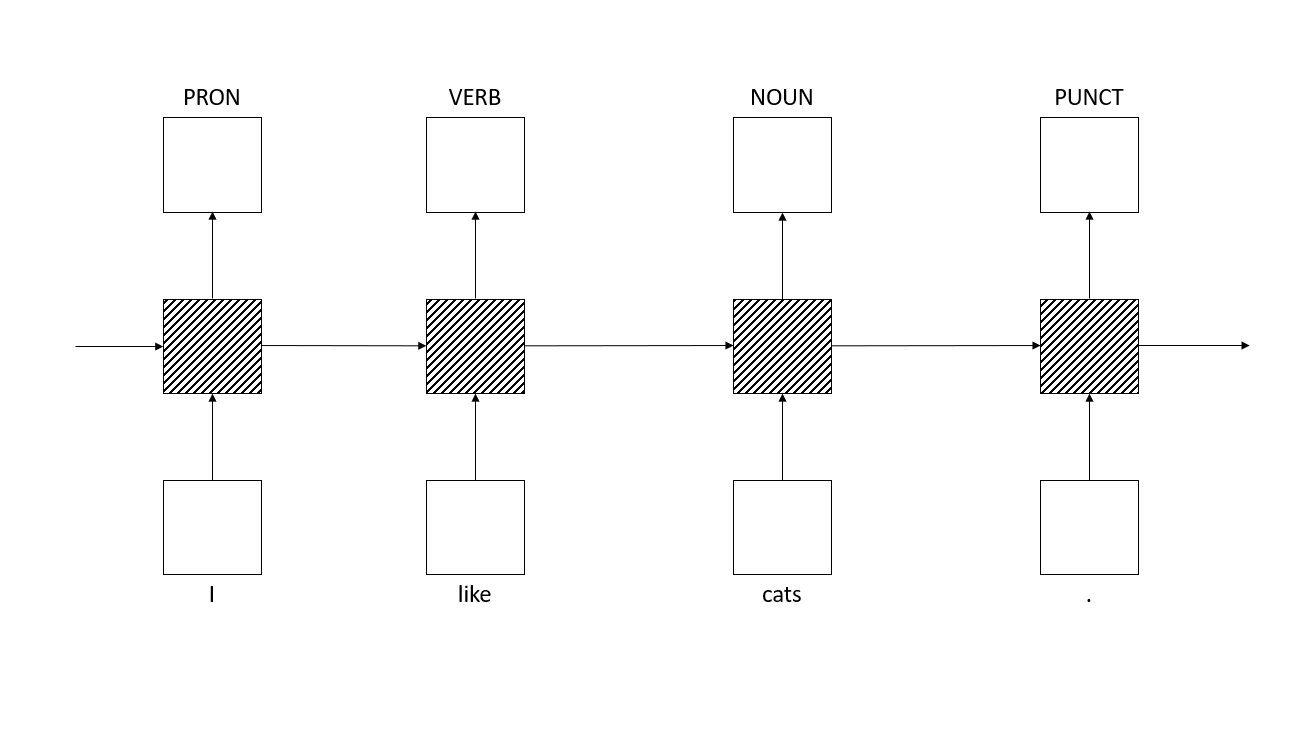

Here, a square with the diagonal stripes is an **RNN unit**. You may notice, that it has one input and two outputs. 

To better understand what these outputs mean and how we can use them, let's look inside one of the RNN units, or **RNN cells**.

![RNN cell](http://dprogrammer.org/wp-content/uploads/2019/04/RNN_Core2-768x491.png)

This simple cell consists of only one TanH activation function (it can be replaced with ReLU). As an input, it takes the **hidden state** from the previous cell and the input itself which can be a word embedding, for example. In this case, the output hidden state is the same as the output of the cell. Passing this hidden state as an input to the next cell will transfer some information from the context.

Now, the cell above is very simple. There are more efficient variations like [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) or [GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit). 

Let's look inside an LSTM cell.

<a title="Guillaume Chevalier / CC BY (https://creativecommons.org/licenses/by/4.0)" href="https://commons.wikimedia.org/wiki/File:The_LSTM_cell.png"><img width="512" alt="The LSTM cell" src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/The_LSTM_cell.png/512px-The_LSTM_cell.png"></a>

We can see, that it has more inputs and outputs, as well as more layers inside the cell, but the main concept stays the same. This time $h_t$ is a hidden state at the timestamp $t$, and $c_t$ is a **cell state** at the timestep $t$. 

As we are going to impliment an LSTM model in this Lab, we need to understand how to route the inputs and outputs correctly. The inside magic of the network will be done for us by PyTorch. Our job is just to plug in the wires into the correct slots.

You can also read more about LSTMs [in this blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

## POS tagging for your language

In this Lab, you are going to create a pos tagger for the language of your choice. I encourage you to try to use your native language. 

First, let's import everything that we might need.

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pack_padded_sequence, pad_packed_sequence, PackedSequence
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
from time import time
from datetime import datetime

from pathlib import Path
from collections import Counter

from typing import List, Dict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We are going to need the pretrained word vectors. For this network, we can use the [Fasttext](https://fasttext.cc/docs/en/crawl-vectors.html) vectors since they have a lot of languages available. I am going to download the vectors for my native language which is Russian. To download the vectors for your language, you need to replace the link with your **text vectors** from the table at the link above.

For example, that link for Estonian word vectors will be: `https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.et.300.vec.gz`

Run the two cells below to download and unpack the vectors.

In [0]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz

In [0]:
!gunzip cc.ru.300.vec.gz
!mkdir vector_cache/
!mv cc.ru.300.vec vector_cache/

Next, we need the data to train on. For this task, we are going to use [Universal Dependencies](https://universaldependencies.org/) data. It has labelled corpora for morphological tagging and syntax parsing for over than 70 languages. You need to choose your language from the official UD page, choose the treebank that you like and follow the GitHub link to it. Then, from GitHub, copy the link from the green "Clone or download" button and replace it in the cell below. 

Also, replace the name of your treebank in the `!mv` command.

For example, if I choose the EDT treebank for Estonian from [here](https://universaldependencies.org/#estonian-treebanks), the GitHub link is going to be `https://github.com/UniversalDependencies/UD_Estonian-EDT.git` and the name of the treebank is `UD_Estonian-EDT`, which is the name of the repository.

In [0]:
!git clone https://github.com/UniversalDependencies/UD_Russian-Taiga.git

In [0]:
!mkdir data/
!mv UD_Russian-Taiga/ data/

This part is moslty the same as in the [Lab 4](https://github.com/501Good/tartu-nlp-2020/blob/master/labs/lab4/Lab4_TextClassificationCNN.ipynb). 

**Don't forget to change the `VEC_PATH` and `DATA_PATH` variables to match your data!**

In [0]:
PAD = '<PAD>'
PAD_ID = 0
UNK = '<UNK>'
UNK_ID = 1
VOCAB_PREFIX = [PAD, UNK]

VEC_PATH = Path('vector_cache') / 'cc.ru.300.vec'
DATA_PATH = Path('data') / 'UD_Russian-Taiga'
MAX_VOCAB = 25000

batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed = 42

## Building the Vocabs

In [0]:
class BaseVocab:
    def __init__(self, data, idx=0, lower=False):
        self.data = data
        self.lower = lower
        self.idx = idx
        self.build_vocab()
        
    def normalize_unit(self, unit):
        if self.lower:
            return unit.lower()
        else:
            return unit
        
    def unit2id(self, unit):
        unit = self.normalize_unit(unit)
        if unit in self._unit2id:
            return self._unit2id[unit]
        else:
            return self._unit2id[UNK]
    
    def id2unit(self, id):
        return self._id2unit[id]
    
    def map(self, units):
        return [self.unit2id(unit) for unit in units]

    def unmap(self, ids):
        return [self.id2unit(idx) for idx in ids]
        
    def build_vocab(self):
        NotImplementedError()
        
    def __len__(self):
        return len(self._unit2id)

In [0]:
class PretrainedWordVocab(BaseVocab):
    def build_vocab(self):
        self._id2unit = VOCAB_PREFIX + self.data
        self._unit2id = {w:i for i, w in enumerate(self._id2unit)}

In addition to the pretrained vocab, we are going to create a word vocab that we are going to use to encode the words and the pos tags. It extends the same `BaseVocab` class but has a different way of initialization. 

The `self.data` in this vocab is going to be a list of list of lists, like that: 

`[[['I', 'PRON'], ['like', 'VERB'], ['cats', 'NOUN'], ['.', 'PUNCT']]]`.

We also added the `idx` parameter for the `BaseVocab` to select the appropriate element for each word array in out data.

In [0]:
class WordVocab(BaseVocab):
    def build_vocab(self):
        if self.lower:
            counter = Counter([w[self.idx].lower() for sent in self.data for w in sent])
        else:
            counter = Counter([w[self.idx] for sent in self.data for w in sent])

        self._id2unit = VOCAB_PREFIX + list(sorted(list(counter.keys()), key=lambda k: counter[k], reverse=True))
        self._unit2id = {w:i for i, w in enumerate(self._id2unit)}

## Building the Dataset

The `Pretrain` class is the same as in the [Lab 4](https://github.com/501Good/tartu-nlp-2020/blob/master/labs/lab4/Lab4_TextClassificationCNN.ipynb).

In [0]:
class Pretrain:
    def __init__(self, vec_filename, max_vocab=-1):
        self._vec_filename = vec_filename
        self._max_vocab = max_vocab
        
    @property
    def vocab(self):
        if not hasattr(self, '_vocab'):
            self._vocab, self._emb = self.read()
        return self._vocab
    
    @property
    def emb(self):
        if not hasattr(self, '_emb'):
            self._vocab, self._emb = self.read()
        return self._emb
        
    def read(self):
        if self._vec_filename is None:
            raise Exception("Vector file is not provided.")
        print(f"Reading pretrained vectors from {self._vec_filename}...")
        
        words, emb, failed = self.read_from_file(self._vec_filename, open_func=open)
        
        if failed > 0: # recover failure
            emb = emb[:-failed]
        if len(emb) - len(VOCAB_PREFIX) != len(words):
            raise Exception("Loaded number of vectors does not match number of words.")
            
        # Use a fixed vocab size
        if self._max_vocab > len(VOCAB_PREFIX) and self._max_vocab < len(words):
            words = words[:self._max_vocab - len(VOCAB_PREFIX)]
            emb = emb[:self._max_vocab]
                
        vocab = PretrainedWordVocab(words, lower=True)
        
        return vocab, emb
        
    def read_from_file(self, filename, open_func=open):
        """
        Open a vector file using the provided function and read from it.
        """
        first = True
        words = []
        failed = 0
        with open_func(filename, 'rb') as f:
            for i, line in enumerate(f):
                try:
                    line = line.decode()
                except UnicodeDecodeError:
                    failed += 1
                    continue
                if first:
                    # the first line contains the number of word vectors and the dimensionality
                    first = False
                    line = line.strip().split(' ')
                    rows, cols = [int(x) for x in line]
                    emb = np.zeros((rows + len(VOCAB_PREFIX), cols), dtype=np.float32)
                    continue

                line = line.rstrip().split(' ')
                emb[i+len(VOCAB_PREFIX)-1-failed, :] = [float(x) for x in line[-cols:]]
                words.append(' '.join(line[:-cols]))
        return words, emb, failed

Since our data is in the [CoNLL-U format](https://universaldependencies.org/format.html) that is basically as tab-separated text document, we are going to create `Word`, `Sentence`, `Document` classes to store all the information about words, sentences, documents.

`Word` class is just going to store all 10 fields with their respecitve names. These are `id`, `text`, `lemma`, `upos`, `xpos`, `feats`, `head`, `deprel`, `deps`, and `misc`. For this model, we are only interested in `text` and `upos` fields, but it's good idea to have all the information nicely stored in case we want to expand our model (that you are going to do in the homework).

`Sentence` class just stores the list of `Word` objects.

`Document` class stores the list of `Sentence` objects and actually reads the text file in the `load_conll` method. `get` method returns a document as a list of lists of lists that we will need to build a `WordVocab`.

In [0]:
FIELD_NUM = 10

class Word:
    def __init__(self, word: List[str]):
        self._id = word[0]
        self._text = word[1]
        self._lemma = word[2]
        self._upos = word[3]
        self._xpos = word[4]
        self._feats = word[5]
        self._head = word[6]
        self._deprel = word[7]
        self._deps = word[8]
        self._misc = word[9]

    @property
    def id(self):
        return self._id

    @property
    def text(self):
        return self._text

    @property
    def lemma(self):
        return self._lemma

    @property
    def upos(self):
        return self._upos

    @property
    def xpos(self):
        return self._xpos

    @property
    def feats(self):
        return self._feats

    @property
    def head(self):
        return self._head

    @property
    def deprel(self):
        return self._deprel

    @property
    def deps(self):
        return self._deps

    @property
    def misc(self):
        return self._misc


class Sentence:
    def __init__(self, words: List[List[str]]):
        self._words = [Word(w) for w in words]

    @property
    def words(self):
        return self._words

class Document:
    def __init__(self, file_path):
        self._sentences = []
        self.load_conll(open(file_path, encoding='utf-8'))


    def load_conll(self, f, ignore_gapping=True):
        """ Load the file or string into the CoNLL-U format data.
        Input: file or string reader, where the data is in CoNLL-U format.
        Output: a list of list of list for each token in each sentence in the data, where the innermost list represents 
        all fields of a token.

        Taken and modified from Stanza: https://github.com/stanfordnlp/stanza/blob/master/stanza/utils/conll.py
        Stanza is released under the Apache License, Version 2.0.
        """
        # f is open() or io.StringIO()
        doc, sent = [], []
        for line in f:
            line = line.strip()
            if len(line) == 0:
                if len(sent) > 0:
                    doc.append(Sentence(sent))
                    sent = []
            else:
                if line.startswith('#'): # skip comment line
                    continue
                array = line.split('\t')
                if ignore_gapping and '.' in array[0]:
                    continue
                assert len(array) == FIELD_NUM, \
                        f"Cannot parse CoNLL line: expecting {FIELD_NUM} fields, {len(array)} found."
                sent += [array]
        if len(sent) > 0:
            doc.append(Sentence(sent))
        self._sentences = doc

    
    @property
    def sentences(self):
        return self._sentences


    def get(self, fields, as_sentences=False):
        """Taken and modified from Stanza: https://github.com/stanfordnlp/stanza/blob/master/stanza/models/common/doc.py
        Stanza is released under the Apache License, Version 2.0.
        """
        assert isinstance(fields, list), "Must provide field names as a list."
        assert len(fields) >= 1, "Must have at least one field."

        results = []
        for sentence in self.sentences:
            cursent = []
            units = sentence.words
            for unit in units:
                if len(fields) == 1:
                    cursent += [getattr(unit, fields[0])]
                else:
                    cursent += [[getattr(unit, field) for field in fields]]

            # decide whether append the results as a sentence or a whole list
            if as_sentences:
                results.append(cursent)
            else:
                results += cursent
        return results

Finally, to read the data, we are going to create `CONLLUDataset` class that implements the [`Dataset`](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) class from PyTorch.

First, we are going to initialize the pretrain vocab by calling `pretrain.vocab` and saving it in the `self.pretrain_vocab` variable. 

Next, we read the data with `self.load_doc()` method. We are going to pass a `Document` object that we created before to this method.

Then, we initialize the vocabs with the data that we just read with the `self.init_vocab` method and store them inside the `self.vocab` variable.

Finally, we preprocess the data with `self.preprocess` method. In this method, we are turning the words and upos tags into the respective indices in their vocabs.

In [0]:
class CONLLUDataset(Dataset):
    def __init__(self, doc: Document, pretrain: Pretrain, 
                 vocab: Dict[str, BaseVocab] = None, test: bool = False):
        self.pretrain_vocab = pretrain.vocab
        self.test = test
        data = self.load_doc(doc)

        if vocab is None:
            self.vocab = self.init_vocab(data)
        else:
            self.vocab = vocab

        self.data = self.preprocess(data, self.vocab, self.pretrain_vocab)

    def init_vocab(self, data: List) -> Dict:
        wordvocab = WordVocab(data, idx=0)
        uposvocab = WordVocab(data, idx=1)
        vocab = {
            'word': wordvocab,
            'upos': uposvocab}
        return vocab

    def preprocess(self, data: List, vocab: Dict[str, BaseVocab], 
                   pretrain_vocab: PretrainedWordVocab) -> List[List[int]]:
        processed = []
        for sent in data:
            processed_sent = [vocab['word'].map([w[0] for w in sent])]
            processed_sent += [vocab['upos'].map([w[1] for w in sent])]
            processed_sent += [pretrain_vocab.map([w[0].lower() for w in sent])]
            processed.append(processed_sent)
        return processed
        
    def load_doc(self, doc: Document) -> List:
        data = doc.get(['text', 'upos'], as_sentences=True)
        return data
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [0]:
pretrain = Pretrain(VEC_PATH, MAX_VOCAB)

In [0]:
train_doc = Document(DATA_PATH / 'ru_taiga-ud-train.conllu')
train_dataset = CONLLUDataset(train_doc, pretrain)

When creating a development data set, we should use the same vocabs as in the training set so that the mappings from words to ids are the same. We can extract the vocabs from the `train_dataset` by addressing the `vocab` attribute. The pretrained vocab is stored in the `pretrain` object already.

In [0]:
vocab = train_dataset.vocab
dev_doc = Document(DATA_PATH / 'ru_taiga-ud-dev.conllu')
dev_dataset = CONLLUDataset(dev_doc, pretrain, vocab=vocab, test=True)

In [0]:
train_dataset[0]

As usual, we need to specify the `collate_fn` for the [`DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader). 

Last time, we padded all the sentences with `0` by hand to make them all equal length and allow constructing the batch matrix. We can do that now but it will create a lot of unnecessary computations for the paddings. 

Luckily for us, PyTorch has a [`PackedSequence`](https://pytorch.org/docs/stable/nn.html?highlight=packedsequence#torch.nn.utils.rnn.PackedSequence) class as well as [`pad_sequence`](https://pytorch.org/docs/stable/nn.html?highlight=pad_sequence#torch.nn.utils.rnn.pad_sequence), [`pack_padded_sequence`](https://pytorch.org/docs/stable/nn.html?highlight=pack_padded_sequence#torch.nn.utils.rnn.pack_padded_sequence) and [`pad_packed_sequence`](https://pytorch.org/docs/stable/nn.html?highlight=pad_packed_sequence#torch.nn.utils.rnn.pad_packed_sequence) objects. Let's see what each of them does and how we can benefit from them in our model. 

`pad_sequence` function is prettry straightforward. As the name suggests, it pads the sequences to the same length. So, let's say we have $64$ sentences in out batch, all of which are of different length. `pad_sequence` is going to take them as a list of 64 tensors and return a tensor of size $B \times T$, where $B$ is the batch size and $T$ is the length of the longest sentence in the batch.

`pack_padded_sequence` function is going to take our padded sequence as the original lengths of the sequences (i.e. before paddind) and return a `PackedSequence` object that we are going to feed to the neural network. As you may notice, we saved the lengths of each sequence in the `sent_lens` before padding. This `PackedSequence` object is going to ensure that our model doesn't perform tons of useless computations on the padding symbols. We can use `PackedSequence` object in the loss function as well.

`pad_packed_sequence` function does the complete opposite of what `pack_padded_sequence` does. It takes a `PackedSequence` object as an input and returns a padded tensor of size $B \times T$.

In [0]:
def pad_collate(batch):
    (sents, upos, pretrained) = zip(*batch)

    sent_lens = [len(s) for s in sents]

    sents = [torch.LongTensor(w).to(device) for w in sents]
    upos = [torch.LongTensor(u).to(device) for u in upos]
    pretrained = [torch.LongTensor(p).to(device) for p in pretrained]

    sent_pad = pad_sequence(sents, batch_first=True, padding_value=PAD_ID)
    upos_pad = pad_sequence(upos, batch_first=True, padding_value=PAD_ID)
    pretrained_pad = pad_sequence(pretrained, batch_first=True, padding_value=PAD_ID)

    sent_pad = sent_pad.to(device)
    upos_pad = upos_pad.to(device)
    pretrained_pad = pretrained_pad.to(device)

    return sent_pad, upos_pad, pretrained_pad, sent_lens

In [0]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_dataset, collate_fn=pad_collate)

In [0]:
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=shuffle_dataset, collate_fn=pad_collate)

## Define the model

To better understand the model architecture, it's better to make a visual representation of it.

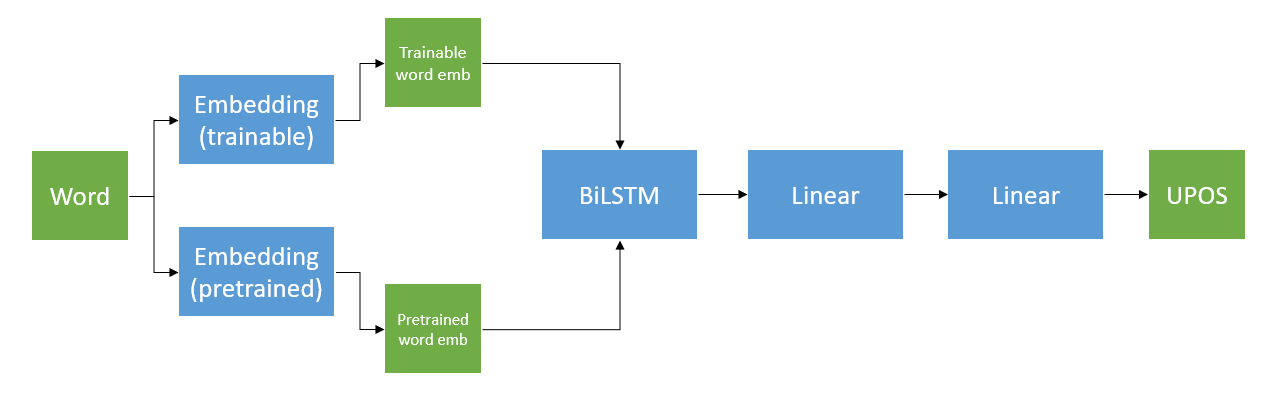

As we can see, the model will have two embedding layers, one is going to be trainable and another one is going to stay frozen and contained already pretrained word vectors that we downloaded before. 

Then, we have a BiLSTM layer which stands for a Bidirectional LSTM. You can see it simply as two LSTM layers but one is passing the hidden states from left to right and another one from right to left. You can see the comparison of LSTM and BiLSTM on the picture below:

![BiLSTM vs LSTM](https://www.researchgate.net/profile/Arvind_Mohan/publication/324769532/figure/fig2/AS:619510805561344@1524714294669/LSTM-and-BiLSTM-Architectures.png)
Image from: *Mohan, Arvind & Gaitonde, Datta. (2018). A Deep Learning based Approach to Reduced Order Modeling for Turbulent Flow Control using LSTM Neural Networks.*

Finally, we have two [Linear layers](https://pytorch.org/docs/stable/nn.html?highlight=linear#torch.nn.Linear) with a [ReLU activation function](https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU) in-between that are going to map the output of the LSTM layer to the probabilities of each pos tag. Since each word can have one and only one pos tag, we will just take the index of the maximum probability to make the prediction.

To optimize the model, we use [cross-entropy loss](https://pytorch.org/docs/stable/nn.html?highlight=crossentropy#torch.nn.CrossEntropyLoss) fucntion. Since we give a `PackedSequence` as an input to the model, the output will also be a `PackedSequence`. That means that we also need to transform the correct tags to a `PackedSequence` and take the `data` attribute from it to match the output of he model.

Also, the model has many tricky transformations to fit the data into the correct modules. Let's go line by line in the `forward()` method.

First, we create an `inputs = []` list to store our inputs. Then, we get the trainable word embeddings for our first input with `self.word_emb`. We repeat the same for the `self.pretrained_emb` with the only difference that we put the embeddings through the linear layer to transform them to the dimension that we want.

After that, we need to concatenate the inputs. We basically add a pretrained embedding to the end of the word embedding. Finally, we pack the inputs to put the into the LSTM. Pay attention that we specify `enforce_sorted = False` flag because we didn't sort the sentences by length inside of the batch. 

Now, we can finally put all of that into the `self.lstm` layer. We take the `data` from the output, which is also a `PackedSequence`. We do it because we don't want to perform extra operations on the padding in the linear layers and `PackedSequence` inputs are only supported by RNNs. To overcome this, we create a `PackedSequence` from the linear output manually. Even though the PyTorch documentation [strongly recommends against creaing a `PackedSequence` maunally](https://pytorch.org/docs/stable/nn.html?highlight=pack_sequence#torch.nn.utils.rnn.PackedSequence), it seems to be the only workaround for now. It is important that you don't forget to put all the parameters from the original packed sequence like `batch_sizes`, `sorted_indices`, and `unsorted_indices`. If you don't specify the last two, `pad_packed_sequence()` function is going to sort your predictions automatically, and thus you will lose the correct order of your predictions and they become practically useless.

Finally, we take the index with maximum probability for each prediction which is going to be the index of the pos tag in the vocabulary. The last step is calculate the loss.

In [0]:
class Tagger(nn.Module):
    def __init__(self, vocab: Dict[str, BaseVocab], word_emb_dim: int,
                 transformed_dim: int, emb_matrix: np.ndarray, hidden_dim: int,
                 upos_clf_hidden_dim: int, num_layers: int, dropout: int):
        super().__init__()

        self.vocab = vocab
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        input_size = 0

        self.word_emb = nn.Embedding(len(vocab['word']), word_emb_dim, padding_idx=0)
        input_size += word_emb_dim

        self.pretrained_emb = nn.Embedding.from_pretrained(torch.from_numpy(emb_matrix), freeze=True)
        self.trans_pretrained = nn.Linear(emb_matrix.shape[1], transformed_dim, bias=False)
        input_size += transformed_dim

        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.lstm_h_init = nn.Parameter(torch.zeros(2 * num_layers, 1, hidden_dim))
        self.lstm_c_init = nn.Parameter(torch.zeros(2 * num_layers, 1, hidden_dim))

        self.upos_hid = nn.Linear(2* hidden_dim, upos_clf_hidden_dim)
        self.upos_clf = nn.Linear(upos_clf_hidden_dim, len(vocab['upos']))

        self.crit = nn.CrossEntropyLoss(ignore_index=0)

        self.drop = nn.Dropout(dropout)

    
    def forward(self, sent_pad, upos_pad, pretrained_pad, sent_lens):
        inputs = []

        word_emb = self.word_emb(sent_pad)
        inputs += [word_emb]

        pretrained_emb = self.pretrained_emb(pretrained_pad)
        pretrained_emb = self.trans_pretrained(pretrained_emb)
        inputs += [pretrained_emb]

        lstm_inputs = torch.cat([x for x in inputs], 2)
        lstm_inputs = self.drop(lstm_inputs)
        lstm_inputs = pack_padded_sequence(lstm_inputs, sent_lens, batch_first=True, enforce_sorted=False)

        lstm_outputs, _ = self.lstm(
            lstm_inputs, 
            (self.lstm_h_init.expand(2 * self.num_layers, sent_pad.size(0), self.hidden_dim).contiguous(), 
             self.lstm_c_init.expand(2 * self.num_layers, sent_pad.size(0), self.hidden_dim).contiguous())
        )
        lstm_outputs = lstm_outputs.data

        upos_hid = F.relu(self.upos_hid(self.drop(lstm_outputs)))
        upos_pred = self.upos_clf(self.drop(upos_hid))

        pred = PackedSequence(upos_pred, lstm_inputs.batch_sizes,
                              lstm_inputs.sorted_indices, lstm_inputs.unsorted_indices)
        pred = pad_packed_sequence(pred, batch_first=True)[0]
        pred = pred.max(2)[1]
        upos = pack_padded_sequence(upos_pad, sent_lens, batch_first=True, enforce_sorted=False).data
        loss = self.crit(upos_pred, upos)

        return loss, pred

In the `Trainer` class, we are going to update the model's weights in the `update()` method. This method performs the forward pass of the model, backward pass on the loss and updates the optimizer.

`predict()` method is used for inference. It only performs the forward pass on the model and trims the predictions to their original lengths.

In [0]:
class Trainer:
    def __init__(self, vocab, word_emb_dim, transformed_dim, emb_matrix, hidden_dim, upos_clf_hidden_dim, num_layers, dropout, use_cuda=False):
        self.use_cuda = use_cuda

        self.vocab = vocab
        self.model = Tagger(vocab, word_emb_dim, transformed_dim, emb_matrix, hidden_dim, upos_clf_hidden_dim, num_layers, dropout)
        self.parameters = [p for p in self.model.parameters() if p.requires_grad]

        self.model.to(device)

        self.optimizer = torch.optim.Adam(self.parameters)
 
    def update(self, batch, eval=False):
        sent_pad, upos_pad, pretrained_pad, sent_lens = batch

        if eval:
            self.model.eval()
        else:
            self.model.train()
            self.optimizer.zero_grad()

        loss, _ = self.model(sent_pad, upos_pad, pretrained_pad, sent_lens)
        loss_val = loss.data.item()
        if eval:
            return loss_val

        loss.backward()
        self.optimizer.step()

        return loss_val


    def predict(self, batch):
        sent_pad, upos_pad, pretrained_pad, sent_lens = batch

        self.model.eval()
        batch_size = sent_pad.size(0)
        _, pred = self.model(sent_pad, upos_pad, pretrained_pad, sent_lens)
        # Transform the indices to the pos tags
        pred = [self.vocab['upos'].unmap(sent) for sent in pred.tolist()]
        # Trim the predictions to their original lengths
        pred_tokens = [[pred[i][j] for j in range(sent_lens[i])] for i in range(batch_size)]

        return pred_tokens

In [0]:
word_emb_dim = 75
transformed_dim = 125
emb_matrix = pretrain.emb
hidden_dim = 200
upos_clf_hidden_dim = 400
num_layers = 2
dropout = 0.5
use_cuda = True if device == 'cuda' else False

In [0]:
trainer = Trainer(vocab, word_emb_dim, transformed_dim, emb_matrix, hidden_dim, upos_clf_hidden_dim, num_layers, dropout, use_cuda)

In [0]:
global_step = 0
max_steps = 50000
dev_score_history = []
format_str = '{}: step {}/{}, loss = {:.6f} ({:.3f} sec/batch)'
last_best_step = 0

log_step = 20
eval_interval = 100

In [0]:
train_loss = 0
while True:
    do_break = False
    for batch in train_loader:
        start_time = time()
        global_step += 1
        loss = trainer.update(batch, eval=False)
        train_loss += loss

        if global_step % log_step == 0:
            duration = time() - start_time
            print(format_str.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), global_step,\
                    max_steps, loss, duration))
            
        if global_step % eval_interval == 0:
            print("Evaluating on dev set...")
            dev_preds = []
            dev_words = []
            for batch in dev_loader:
                batch_size = batch[0].size(0)
                preds = trainer.predict(batch)
                dev_preds += preds
                # Keep the original sentence
                pred_sents = [[batch[0][i][j] for j in range(batch[3][i])] for i in range(batch_size)]
                dev_words += [vocab['word'].unmap(sent) for sent in [sent for sent in pred_sents]]
            
            train_loss = train_loss / eval_interval
            print("step {}: train_loss = {:.6f}".format(global_step, train_loss))
            # Shows one prediction for a sanity check
            print(f"Preds: {list(zip(dev_preds[0], dev_words[0]))}")
            train_loss = 0

        if global_step >= max_steps:
            do_break = True
            break

        if do_break:
            break